## Introduction

In this notebook we solve the ```CartPolo-v0``` problem from [OpenAI Gym](https://gym.openai.com/), a toolkit for developing and comparing Reinforcement Learning (RL) algorithms. We will use a nature inspiried optimization technique known as [_Simulated Annealing_](https://en.wikipedia.org/wiki/Simulated_annealing#Overview), applied to policy exploration.

![](http://gym.openai.com/videos/2019-04-06--My9IiAbqha/CartPole-v1/poster.jpg)

This notebook **is not** an introcution to RL, and does not explain concepts like Markov Decision Processes, states, rewards, value functions, policies and so on. For a hands on introduction to RL I recommend [Packt: Deep Reinforcement Learning Hands-On](https://www.amazon.com/Deep-Reinforcement-Learning-Hands-Q-networks-ebook/dp/B076H9VQH6/ref=sr_1_1_sspa?keywords=pocket+reinforcement+learning&qid=1555782065&s=gateway&sr=8-1-spons&psc=1). For a solid theoretical treatment of the subject there is nothing better than [Sutton & Barto: Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html), which is available for free online, and can also be [purchased online](https://www.amazon.com/Reinforcement-Learning-Introduction-Adaptive-Computation/dp/0262193981/ref=sr_1_4?crid=17M2H3J2R3L7Z&keywords=sutton+reinforcement+learning&qid=1555782219&s=gateway&sprefix=sutton+re%2Caps%2C200&sr=8-4).

## Setup

Before we can get our hands dirty there are a few things we need to install. The following cell takes care of all that:

In [1]:
import sys
!{sys.executable} -m pip install gym seaborn==0.9.0 matplotlib > /dev/null

import numpy as np
import gym

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


This is all the setup we need. In the following section we will introduce the foundational Gym concepts, and will execute an actual simulation.

## Simulated Annealing

_From [Mathworks](https://www.mathworks.com/help/gads/what-is-simulated-annealing.html)_: Simulated annealing is a method for solving unconstrained and bound-constrained optimization problems. The method models the physical process of heating a material and then slowly lowering the temperature to decrease defects, thus minimizing the system energy.

At each iteration of the simulated annealing algorithm, a new point is randomly generated. The distance of the new point from the current point, or the extent of the search, is based on a probability distribution with a scale proportional to the temperature. The algorithm accepts all new points that lower the objective, but also, with a certain probability, points that raise the objective. By accepting points that raise the objective, the algorithm avoids being trapped in local minima, and is able to explore globally for more possible solutions. An annealing schedule is selected to systematically decrease the temperature as the algorithm proceeds. As the temperature decreases, the algorithm reduces the extent of its search to converge to a minimum.

```Python
Let s = s0
For k = 0 through kmax (exclusive):
  T ← temperature( kmax/(k+1) )
  Pick a random neighbour, snew ← neighbour(s)
  If P(E(s), E(snew), T) ≥ random(0, 1):
  s ← snew
Output: the final state s
```

Where

* s is the current policy
* k is the current step
* T is the current temperature
* neighbour is a function to generate a new policy
* $P(E(s), E(snew), T)$ is the probability of choosing the new policy

Basically we need to define 3 elements:

* the function to generate new candidate states
* the probability of choosing a new state, based on the energies and the current temperature $P(E(s), E(snew), T)$
* the temperature schedule, i.e. how T changes over time

One traditinally used $P(E(s), E(snew), T)$ is:

$
if E(s) < E(snew), exp(-(\frac{E(snew) - E(s))}{T}) \\
if E(s) \geq E(snew) \to 1
$

In a reinforcement learning problem $E(s) = 1 / reward$, keeping in mind that s is not the state of the environment in the RL problem, but a policy.

## OpenAI Gym

OpenAI Gym is very flexible and abstracts many details to make experimentation really fast. The key to this are its foundational concepts: environment, observations, actions and spaces.

**Environment**: An environment is a test problem. It models the "world" in which the agent exists, generates observations, defines possible actions and determines the reward the agent gets at different points in time. OpenAI Gym is packed with envirnoments. Environments are instanciated by name:

```python
import gym
env = gym.make('CartPole-v0')
env.reset()
```

**Observations**: Observations allow us to determine the state of the environment, the reward obtained after executing the last actions, wheter or not the simulation has finished, and some extra bits and pieces of information. The ```step``` method of the _environment_ gives us access to this information:

```python
import gym
env = gym.make('CartPole-v0')
for i_episode in range(200):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()
```

**Actions**: The purpose of Reinforcement Learning is to learn what is the optimal action that an agent in a particular environment can take at any point in time. In OpenAI Gym the set of possible actions is defined by the environment, and can be access via its action_space. Spaces are explained next.

```python
# Select a random action
action = env.action_space.sample()
```

**Spaces**: Every environment comes with an action_space and an observation_space. These attributes are of type Space, and they describe the format of valid actions and observations:

In [2]:
import gym
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(4,)


A ```Discrete``` space is basically a set of actions identifed by integers. For dimension $n$ it is basically a set with elements ```range(0, n)```. A ```Box``` is basically an n-dimentional tensor. For instance, a chess board could be represented as a ```Box(8, 8)```.

## Running a simulation

In this section we are going to run but not visualize a simulation. We have not been able to visualize simulations within Jupyter running on EC2.

We are going to use the [CartPole-v0 environment](https://gym.openai.com/envs/CartPole-v0/). CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials. The following code uses random actions, so we are not going to be able to solve the problem.

The observation vector contains the following information: ```[position of cart, velocity of cart, angle of pole, rotation rate of pole]```, and the actions consist of applying a force of $-1$ or $1$ to the cart.

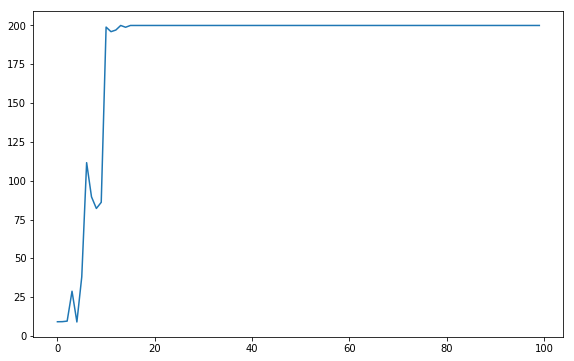

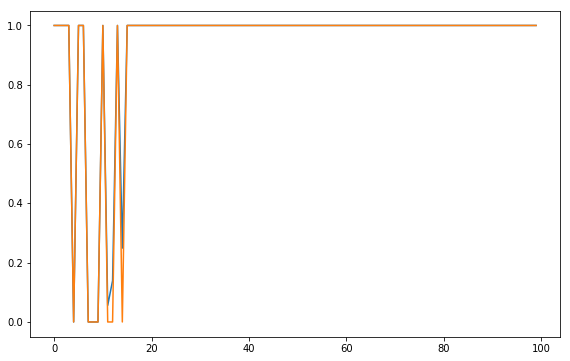

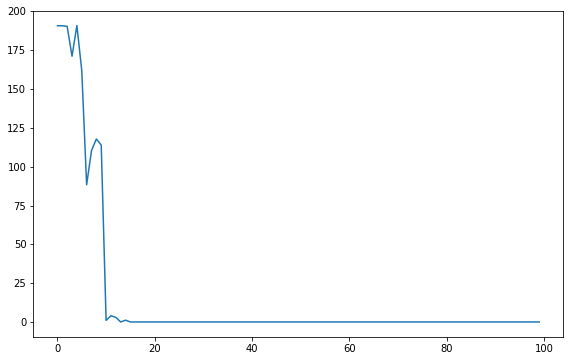

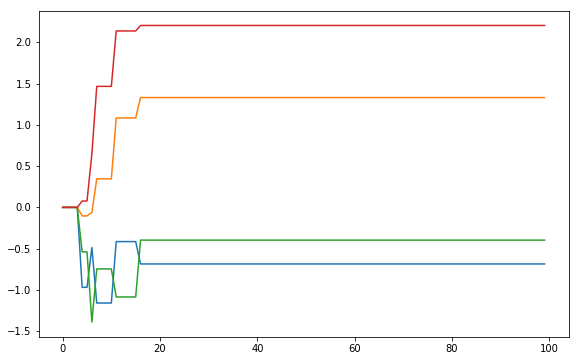

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

env = gym.make('CartPole-v0')


class History(object):
    def __init__(self):
        self.rewards = []
        self.states = []
        self.probs = []
        self.energy = []
        self.changes = []
        
        
class Agent(object):
    def __init__(self, T):
        # Randomly initialize current policy weights
        self.s = np.random.rand(4)
        #self.s = np.array([ 1.21255105,  0.69388881,  0.75884639, -0.02368038])
        #self.s = np.array([1.71575463, 1.4038527,  2.39294741, 1.83749942])
        #self.s = np.array([-0.23641731,  0.91496673,  0.18087727,  1.39950759])
        self.s = np.zeros((4))
        self.s_next = self.s
        # Current policy reward
        self.reward = 0
        # Current temperature
        self.T = T
        # Initial temperature
        self.T0 = T
        # History 
        self.history = History()
        
    def reset(self, T):
        self.T0 = T
        self.T = T
        
    def _energy(self, reward):
        return 200 - reward
    
    def select_action(self, observation, env):
        output = self.s_next.dot(observation)
        log = 1/(1 + np.exp(output))
        if log < 0.5:
            return 1
        else:
            return 0
        
    def update(self, reward):
        # Accounting
        self.history.rewards.append(reward)
        self.history.states.append(self.s)
        
        # Caculate energies
        e_s_next = self._energy(reward)
        e_s = self._energy(self.reward)
        agent.history.energy.append(e_s_next)
        
        # Update temperature
        self.T = np.max([0, self.T - 1])
        
        if e_s_next <= e_s:
            self.s = self.s_next
            self.reward = reward
            self.history.changes.append(1.0)
            self.history.probs.append(1.0)
        else:
            p = 1 / (1 + np.exp((e_s_next - e_s) / (0.0005 * self.T + 1)))
            self.history.probs.append(p)
            #print(e_s, e_s_next, p)
            if p > np.random.rand(1):
                self.history.changes.append(1.0)
                #print("accepting worse state: ", p)
                self.s = self.s_next
                self.reward = reward
            else:
                self.history.changes.append(0.0)

        # Don't mutate if energy is 0. 0 is a global max
        if e_s_next > 0 and (1 - np.random.randint(2)) == 1:
            self.s_next = np.array([v + (1 - 2 * np.random.randint(2)) * np.random.rand() * self.T / self.T0 for v in self.s])
        

temp = 100
agent = Agent(temp)
episodes = 20
total_reward = 0 # Used to calculate the average reward over all episodes

for k in range(temp):
    total_reward = 0
    for episode in range(episodes):
        acc_reward = 0 # Accumulated reward in the current episode
        observation = env.reset()
        t = 0
        while True:
            t += 1
            action = agent.select_action(observation, env) # Select a random action
            observation, reward, done, info = env.step(action)
            acc_reward += reward
            if done:
                break
        total_reward += acc_reward
        
    #print("\nAverage reward over {} episodes is {}".format(episodes, total_reward / episodes))
    agent.update(total_reward / episodes)


env.close()
plt.rcParams['figure.figsize'] = [9.5, 6]
sn.lineplot(x=range(len(agent.history.rewards)), y=agent.history.rewards)
plt.figure()
sn.lineplot(x=range(len(agent.history.probs)), y=agent.history.probs)
sn.lineplot(x=range(len(agent.history.changes)), y=agent.history.changes)

plt.figure()
sn.lineplot(x=range(len(agent.history.energy)), y=agent.history.energy)
plt.figure()
states = np.array(agent.history.states).transpose()

sn.lineplot(x=range(len(states[0])), y=states[0])
sn.lineplot(x=range(len(states[1])), y=states[1])
sn.lineplot(x=range(len(states[2])), y=states[2])
sn.lineplot(x=range(len(states[3])), y=states[3])